# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [3]:
# Load the dataset into a DataFrame
df = pd.read_csv("BirdTraitData.csv", encoding='ISO-8859-1').rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; offal; carcasses': 'Diet_Other'
})
# View the column names
print(df.columns)

Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet_Invertebrates',
       'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds',
       'Diet_Plants', 'Diet_Other', 'TrophicLevel', 'ActivityCycle',
       'ForagingStratum', 'MigratoryStatus', 'IncubationTime', 'ClutchSize',
       'EggLength', 'EggWidth', 'EggMass', 'NestingHabit', 'MaxLongevity',
       'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid', 'Alaotra.Mangoro',
       'Amoron.i.Mania', 'Analamanga', 'Analanjirofo', 'Androy', 'Anosy',
       'Atsimo.Andrefana', 'Atsimo.Atsinanana', 'Atsinanana', 'Betsiboka',
       'Boeny', 'Bongolava', 'DIANA', 'Haute.Matsiatra', 'Ihorombe', 'Itasy',
       'Melaky', 'Menabe', 'SAVA', 'Sofia', 'Vakinankaratra',
       'Vatovavy.Fitovinany', 'Antananarivo', 'Antsiranana', 'Fianarantsoa',
       'Mahajanga', 'Toamasina', 'Toliara', 'References'],
      dtype='object')


In [4]:
# List of key variables to select
key_variables = [
    'AdultBodyMass', 'DietBreadth', 'Diet_Invertebrates', 'Diet_Vertebrates',
    'Diet_Fruits', 'Diet_Flowers', 'Diet_Seeds', 'Diet_Plants', 'Diet_Other',
    'TrophicLevel', 'ActivityCycle', 'ForagingStratum', 'MigratoryStatus',
    'IncubationTime', 'ClutchSize', 'EggLength', 'EggWidth', 'EggMass',
    'NestingHabit', 'MaxLongevity', 'Subarid'
]
# Select only the key variables
df = df[key_variables]
# Print the head of the DataFrame to view the first few rows
print(df.head())

   AdultBodyMass  DietBreadth Diet_Invertebrates Diet_Vertebrates Diet_Fruits  \
0          138.5            2                yes              yes          no   
1         1050.0            1                 no              yes          no   
2          181.0            2                yes              yes          no   
3          292.0            2                yes              yes          no   
4          511.0            2                yes              yes          no   

  Diet_Flowers Diet_Seeds Diet_Plants Diet_Other  TrophicLevel  ...  \
0           no         no          no         no             3  ...   
1           no         no          no         no             3  ...   
2           no         no          no         no             3  ...   
3           no         no          no         no             3  ...   
4           no         no          no         no             3  ...   

   ForagingStratum  MigratoryStatus IncubationTime  ClutchSize  EggLength  \
0        

### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [5]:
# Instantiate the LabelEncoder
label_encoder = LabelEncoder()
# Find all categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
# Loop through each categorical column and apply LabelEncoder
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])
# Print the head of the DataFrame to verify encoding
print(df.head())

   AdultBodyMass  DietBreadth  Diet_Invertebrates  Diet_Vertebrates  \
0          138.5            2                   2                 2   
1         1050.0            1                   1                 2   
2          181.0            2                   2                 2   
3          292.0            2                   2                 2   
4          511.0            2                   2                 2   

   Diet_Fruits  Diet_Flowers  Diet_Seeds  Diet_Plants  Diet_Other  \
0            1             1           1            1           1   
1            1             1           1            1           1   
2            1             1           1            1           1   
3            1             1           1            1           1   
4            1             1           1            1           1   

   TrophicLevel  ...  ForagingStratum  MigratoryStatus  IncubationTime  \
0             3  ...                3                0            31.0   
1         

### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [7]:
# Use mode to fill missing values in numeric columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    mode_value = df[col].mode()[0]  # Get the mode for the column
    df[col].fillna(mode_value, inplace=True)  # Impute the missing values with the mode
# Use mode to fill missing values in categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    mode_value = df[col].mode()[0]  # Get the mode for the column
    df[col].fillna(mode_value, inplace=True)  # Impute the missing values with the mode

In [8]:
# Drop 'Subarid' column from features (X) and define it as target (y)
X = df.drop(columns=['Subarid'])
y = df['Subarid']
# Perform train-test split with 70/30 and random_state=808
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)
# Initialize a Bagging Classifier with 100 trees, oob_score=True, bootstrap=True, random_state=808
bagging_classifier = BaggingClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=808)
# Train the model
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [9]:
# Generate predictions using the trained model
y_pred = bagging_classifier.predict(X_test)
# Calculate the Out-of-Bag (OOB) Score
oob_score = bagging_classifier.oob_score_
# Compute model accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
# Print the OOB score and accuracy score
print(f"Out-of-Bag (OOB) Score: {oob_score:.4f}")
print(f"Model Accuracy on Test Set: {accuracy:.4f}")

Out-of-Bag (OOB) Score: 0.8817
Model Accuracy on Test Set: 0.9452


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

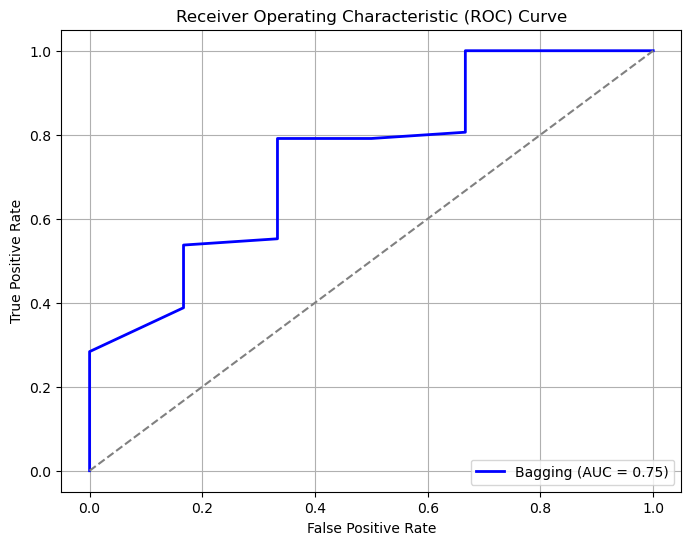

In [10]:
# ROC Curve and AUC Calculation
fpr, tpr, thresholds = roc_curve(y_test, bagging_classifier.predict_proba(X_test)[:, 1])
roc_auc_bagging = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Bagging (AUC = {roc_auc_bagging:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

*The ROC curve has an AUC of 0.75 and accuracy is high at 94.52%, implying that the model is performing well in classification. Though it may not be as strong in ranking predictions across thresholds showing that the dataset is imbalanced.*

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [13]:
# Separate majority and minority classes
majority = y_train.value_counts().idxmax()
minority = y_train.value_counts().idxmin()

X_majority = X_train[y_train == majority]
y_majority = y_train[y_train == majority]
X_minority = X_train[y_train == minority]
y_minority = y_train[y_train == minority]

# Upsample the minority class
X_minority_upsampled, y_minority_upsampled = resample(X_minority, y_minority, 
                                                     replace=True, 
                                                     n_samples=len(X_majority), 
                                                     random_state=808)

# Combine majority and upsampled minority class
X_train_balanced = pd.concat([X_majority, X_minority_upsampled])
y_train_balanced = pd.concat([y_majority, y_minority_upsampled])

# Shuffle the dataset
X_train_balanced, y_train_balanced = resample(X_train_balanced, y_train_balanced, 
                                              random_state=808)

# Print value counts 
print(y_train_balanced.value_counts())

Subarid
0    159
1    141
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

Out-of-Bag (OOB) Score - Balanced Data: 0.9700
Model Accuracy on Test Set - Balanced Data: 0.8767


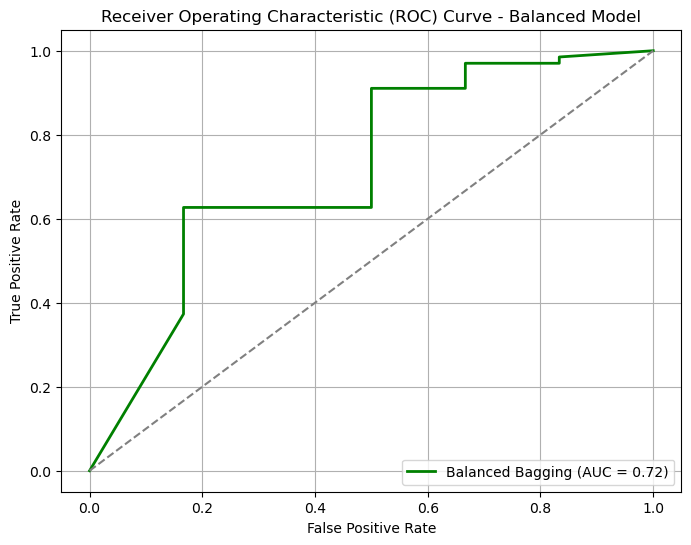

In [14]:
# Initialize the bagging classifier again with the balanced data
bagging_classifier_balanced = BaggingClassifier(n_estimators=100, oob_score=True, 
                                               bootstrap=True, random_state=808)
# Train the model on the balanced data
bagging_classifier_balanced.fit(X_train_balanced, y_train_balanced)
# Generate predictions using the trained model
y_pred_balanced = bagging_classifier_balanced.predict(X_test)
# Calculate the Out-of-Bag (OOB) Score and accuracy
oob_score_balanced = bagging_classifier_balanced.oob_score_
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
# Print the OOB score and accuracy score for the balanced model
print(f"Out-of-Bag (OOB) Score - Balanced Data: {oob_score_balanced:.4f}")
print(f"Model Accuracy on Test Set - Balanced Data: {accuracy_balanced:.4f}")
# Calculate the ROC curve and AUC for the balanced model
fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_test, 
                                                             bagging_classifier_balanced.predict_proba(X_test)[:, 1])
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)
# Plot the ROC curve for the balanced model
plt.figure(figsize=(8, 6))
plt.plot(fpr_balanced, tpr_balanced, color='green', lw=2, 
         label=f'Balanced Bagging (AUC = {roc_auc_balanced:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - Balanced Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

*The second model trained on balanced data had a lower AUC of 0.72 and a lower accuracy of 87.67%. Though we saw that its OOB score improved to 0.97 vs. 0.88 which suggests better generalization. While the upsampling helped make the second model more fair the drop in accuracy shows that the first model benefits from class imbalance. Upsampling is useful because it makes the model more fair and predictions more balanced but performance is lost.*

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

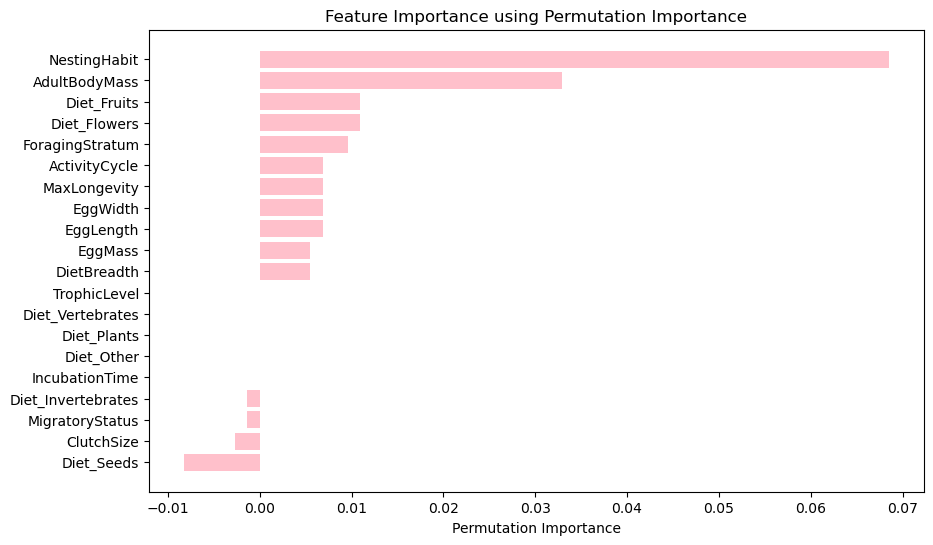

In [16]:
# Calculate permutation importance on the balanced model
perm_importance = permutation_importance(bagging_classifier_balanced, 
                                         X_test, y_test, n_repeats=10, random_state=808)
# Sort the features by importance
sorted_idx = perm_importance.importances_mean.argsort()
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color = "pink")
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance using Permutation Importance')
plt.show()

What features are most important in our model of species distribution?

*The most important features in predicting species distribution in subarid environments are Nesting habit, Adult body mass, and Diet fruits and flowers, though Foraging stratum is not left behind by much. Nesting habit and Adult body mass are defienetely the most important, and Adult body mass is only half as important as Nesting habit. Sounds reasonable for birds.*